In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
import winsound
from glob import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchviz import make_dot
from torchview import draw_graph
from torchsummary import summary

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Conv layer와 FC layer의 weight 수 비교

In [2]:
fc = nn.Linear(in_features=3 * 32 * 32, out_features=4)
cnn = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)

fc_num_weight = np.prod(fc.weight.size()) + fc.bias.size()[0]
cnn_num_weight = np.prod(cnn.weight.size()) + cnn.bias.size()[0]

print("fc layer weight :", fc_num_weight)
print("cnn layer weight :", cnn_num_weight)

fc layer weight : 12292
cnn layer weight : 1792


## block 쌓기

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size,
                              stride=stride, padding=padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [4]:
conv = ConvBlock(3, 64, 3, 1, "same")
temp = torch.randn(1, 3, 32, 32)
conv(temp).size()

torch.Size([1, 64, 16, 16])

## 8.4 컨볼루션 신경망 구현

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mnist_train = datasets.MNIST(root = './data/02/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root = './data/02/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=128, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                           batch_size=128, shuffle=False)

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBlock(1, 6, 5, 1, "same")
        self.conv2 = ConvBlock(6, 16, 5, 1, "valid")
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding="valid")
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(84, 10)
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.relu1(self.fc1(x))
        out = self.fc2(x)
        return out

    
def train_step(model, loader, optimzer, criterion, device):
    model.train()
    epoch_loss = 0
    for i, (data, target) in enumerate(loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if (i + 1) % 100 == 0:
            print("Train Step : {}\tLoss : {:3f}".format(i + 1, loss.item()))
    return epoch_loss / len(loader)


def evaluate_step(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_loss += loss.item()
            correct += output.argmax(1).eq(target).sum()
    return epoch_loss / len(loader), correct / len(loader.dataset)
    
    
model = LeNet().to(device)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    train_loss = train_step(model, mnist_train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate_step(model, mnist_test_loader, criterion, device)
    print(f"EPOCH {epoch + 1:>3d} Train Loss {train_loss:>.3f} Test Loss {test_loss:>.3f} accuracy {test_acc:>3f}")
    print("-"*50, "\n")

Train Step : 100	Loss : 0.366707
Train Step : 200	Loss : 0.194562
Train Step : 300	Loss : 0.181697
Train Step : 400	Loss : 0.125041
EPOCH   1 Train Loss 0.359 Test Loss 0.123 accuracy 0.960900
-------------------------------------------------- 

Train Step : 100	Loss : 0.129643
Train Step : 200	Loss : 0.136415
Train Step : 300	Loss : 0.144595
Train Step : 400	Loss : 0.031688
EPOCH   2 Train Loss 0.091 Test Loss 0.071 accuracy 0.977100
-------------------------------------------------- 

Train Step : 100	Loss : 0.010697
Train Step : 200	Loss : 0.046751
Train Step : 300	Loss : 0.030403
Train Step : 400	Loss : 0.179922
EPOCH   3 Train Loss 0.066 Test Loss 0.062 accuracy 0.981000
-------------------------------------------------- 

Train Step : 100	Loss : 0.026777
Train Step : 200	Loss : 0.052842
Train Step : 300	Loss : 0.015050
Train Step : 400	Loss : 0.087437
EPOCH   4 Train Loss 0.053 Test Loss 0.050 accuracy 0.982500
-------------------------------------------------- 

Train Step : 100

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor()])

cifar10_train = datasets.CIFAR10(root='./data/03', train=True,
                              download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data/03', train=False,
                             download=True, transform=transform)

cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=128, shuffle=True)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=128, shuffle=False)


class Cifar10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = self.build_layer(32, 32, 3, 1, "valid", 2, 0.25)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = self.build_layer(64, 64, 3, 1, "valid", 2, 0.25)
        
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=512)
        self.dr1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        
    def build_layer(self, in_channel, out_channel, kernel_size, stride, padding, pool_size, dropout):
        layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride,
                     padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool_size),
            nn.Dropout(dropout)
        )
        return layer
    
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = self.conv2(x)
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.dr1(self.fc1(x))
        out = self.fc2(x)
        return out
    

model = Cifar10_CNN().to(device)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(50):
    train_loss = train_step(model, cifar10_train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate_step(model, cifar10_test_loader, criterion, device)
    print(f"EPOCH {epoch + 1:>3d} Train Loss {train_loss:>.3f} Test Loss {test_loss:>.3f} accuracy {test_acc:>3f}")
    print("-"*50, "\n")

Files already downloaded and verified
Files already downloaded and verified
Train Step : 100	Loss : 1.704792
Train Step : 200	Loss : 1.569467
Train Step : 300	Loss : 1.513282
EPOCH   1 Train Loss 1.666 Test Loss 1.435 accuracy 0.476600
-------------------------------------------------- 

Train Step : 100	Loss : 1.361169
Train Step : 200	Loss : 1.489731
Train Step : 300	Loss : 1.224488
EPOCH   2 Train Loss 1.339 Test Loss 1.189 accuracy 0.582500
-------------------------------------------------- 

Train Step : 100	Loss : 1.274997
Train Step : 200	Loss : 1.346450
Train Step : 300	Loss : 1.158079
EPOCH   3 Train Loss 1.186 Test Loss 1.042 accuracy 0.633000
-------------------------------------------------- 

Train Step : 100	Loss : 1.177303
Train Step : 200	Loss : 1.028837
Train Step : 300	Loss : 1.128883
EPOCH   4 Train Loss 1.074 Test Loss 1.018 accuracy 0.636100
-------------------------------------------------- 

Train Step : 100	Loss : 0.943723
Train Step : 200	Loss : 0.928613
Train 

## 8.5 우편번 인식기 v.2

In [3]:
# model train
class PostNumber(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="valid")
        self.conv2 = self.build_block(32, 32, 3, 1, "valid", 2, 0.25)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="valid")
        self.conv4 = self.build_block(64, 64, 3, 1, "valid", 2, 0.25)
        self.fc1 = nn.Linear(in_features=1024, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        self.dr1 = nn.Dropout(0.5)
        
    def build_block(self, in_channel, out_channel, kernel_size, stride, padding, pool_size, dropout):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool_size),
            nn.Dropout(dropout)
        )
        return block
    
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = self.conv2(x)
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out
    
    
# model = PostNumber().to(device)    
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# for epoch in range(100):
#     train_loss = train_step(model, mnist_train_loader, optimizer, criterion, device)
#     test_loss, test_acc = evaluate_step(model, mnist_test_loader, criterion, device)
#     print(f"EPOCH {epoch + 1:>3d} Train Loss {train_loss:>.3f} Test Loss {test_loss:>.3f} accuracy {test_acc:>3f}")
#     print("-"*50, "\n")

# torch.save(model.state_dict(), "./saved_model/cnn_v2.pt")

In [5]:
model = PostNumber()
model.load_state_dict(torch.load("./saved_model/cnn_v2.pt"))
model = model.to(device)
model.eval()

def reset():
    global img
    img = np.ones((200, 520, 3), dtype=np.uint8) * 255
    for i in range(5):
        cv2.rectangle(img, (10 + i * 100, 50), (10 + (i + 1) * 100, 150), (0, 0, 255))
    cv2.putText(img, "e:erase s:show r:recognition q:quit", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 1)
    
def grab_numerals():
    numerals = []
    for i in range(5):
        roi = img[51:149, 11+i*100:9+(i+1)*100, 0]
        roi = 255 - cv2.resize(roi, (28, 28), interpolation=cv2.INTER_CUBIC)
        numerals.append(roi)
    numerals = np.array(numerals)
    return numerals

def show():
    numerals = grab_numerals()
    plt.figure(figsize=(25, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(numerals[i], cmap="gray")
        plt.axis("off")
    plt.show()
    
def recognition():
    numerals = grab_numerals()
    numerals = torch.from_numpy(numerals).unsqueeze(1).to(device).float() / 255.0
    res = model(numerals)
    class_id = np.argmax(res.cpu().detach().numpy(), axis=1)
    for i in range(5):
        cv2.putText(img, str(class_id[i]), (50+i*100, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    winsound.Beep(1000, 500)
    
brush_size = 4
l_color = (0, 0, 0)

def writing(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img, (x,y), brush_size, l_color, -1)
    elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(img, (x,y), brush_size, l_color, -1)
        
reset()
cv2.namedWindow("Writing")
cv2.setMouseCallback("Writing", writing)

while True:
    cv2.imshow("Writing", img)
    key = cv2.waitKey(1)
    if key == ord('e'):
        reset()
    elif key == ord('s'):
        show()
    elif key == ord('r'):
        recognition()
    elif key == ord('q'):
        break
        
cv2.destroyAllWindows()

### 8.7.2 사전 학습 모델로 자연 영상 인식

In [27]:
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
model.to(device)
model.eval()
preprocessor = weights.transforms()

# BGR??
img = cv2.imread("./imgs/rabbit.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
x = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device).float()
x = preprocessor(x)

scores, preds_idx = torch.topk(model(x), k=5)

for i in range(5):
    class_id = preds_idx.squeeze()[i]
    cv2.putText(img, weights.meta["categories"][class_id], (10, 20+i*20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
               (0, 0, 0), 1)
cv2.imshow("Recognition result", img)
cv2.waitKey()
cv2.destroyAllWindows()

### 8.7.3 사전 학습 모델로 견종 인식

In [132]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = models.DenseNet121_Weights.IMAGENET1K_V1
model = models.densenet121(weights=weights)
model.classifier = nn.Linear(1024, 120)
model.to(device)
img_dir = "./data/stanford/Images"
label_dict = {}
df = []
for i, label in enumerate(os.listdir("./data/stanford/Images")):
    breed = label.split('-')[1]
    label_dict[breed] = i
    for path in os.listdir(os.path.join(img_dir, label)):
        img_path = os.path.join(img_dir, label, path)
        df.append((img_path, breed))
df = pd.DataFrame(df, columns=["path", "label"])
train_X, test_X, train_y, test_y = train_test_split(df["path"], df["label"], test_size=0.25, random_state=42, stratify=df['label'])
transform = transforms.Compose([
    transforms.ToTensor(),
    weights.transforms()
])
class StanfordDataset(Dataset):
    def __init__(self, img_path_list, label, label_dict, transform=None, target_transform=None):
        self.img_path_list = img_path_list
        self.label = label
        self.label_dict = label_dict
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self,  i):
        label = self.label_dict[self.label[i]]
        
        img = cv2.imread(self.img_path_list[i])
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        return img, label
        
stanford_train_data = StanfordDataset(train_X.to_list(), train_y.to_list(), label_dict, transform)
stanford_test_data = StanfordDataset(test_X.to_list(), test_y.to_list(), label_dict, transform)
stanford_train_loader = torch.utils.data.DataLoader(stanford_train_data, batch_size=16, shuffle=True)
stanford_test_loader = torch.utils.data.DataLoader(stanford_test_data, batch_size=16, shuffle=False)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

# for epoch in range(50):
#     train_loss = train_step(model, stanford_train_loader, optimizer, criterion, device)
#     test_loss, test_acc = evaluate_step(model, stanford_test_loader, criterion, device)
#     print(f"EPOCH {epoch + 1:>3d} Train Loss {train_loss:>.3f} Test Loss {test_loss:>.3f} accuracy {test_acc:>3f}")
#     print("-"*50, "\n")

## 8.8 견종 인식 프로그램

In [ ]:
model = models.densenet121(weights=None)
model.classifier = nn.Linear(1024, 120)
model.load_state_dict(torch.load("./saved_model/dog.pt"))
transform = transforms.Compose([
    transforms.ToTensor(),
    weights.transforms()
])
inverse_dict = {}
for key, value in label_dict.items() :
    inverse_dict[value] = key

    
class DogSpeciesRecognition(QMainWindow):
    def __init__(self) :
        super().__init__()
        self.setWindowTitle('견종 인식')
        self.setGeometry(200,200,700,100)
       
        fileButton=QPushButton('강아지 사진 열기',self) 
        recognitionButton=QPushButton('품종 인식',self)
        quitButton=QPushButton('나가기',self) 
        
        fileButton.setGeometry(10,10,100,30)
        recognitionButton.setGeometry(110,10,100,30)
        quitButton.setGeometry(510,10,100,30)
        
        fileButton.clicked.connect(self.pictureOpenFunction)
        recognitionButton.clicked.connect(self.recognitionFunction)                         
        quitButton.clicked.connect(self.quitFunction)
        
    def pictureOpenFunction(self):
        fname=QFileDialog.getOpenFileName(self,'강아지 사진 읽기','./')           
        self.img=cv2.imread(fname[0])
        if self.img is None: sys.exit('파일을 찾을 수 없습니다.')  
        
        cv2.imshow('Dog image',self.img)          
        
    def recognitionFunction(self):
        x=transform(self.img) 
        res=model(x)	# 예측
        scores, preds_idx = torch.topk(model(x), k=5)
        top5_dog_species_names=[inverse_dict[i] for i in preds_idx]
        for i in range(5):
            prob='('+str(res[top5[i]])+')'
            name=str(top5_dog_species_names[i]).split('-')[1]
            cv2.putText(self.img,prob+name,(10,100+i*30),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),2)
        cv2.imshow('Dog image',self.img)   
        winsound.Beep(1000,500)
                
    def quitFunction(self):
        cv2.destroyAllWindows()        
        self.close()
              
app=QApplication(sys.argv) 
win=DogSpeciesRecognition() 
win.show()
app.exec_()

## 연습문제

In [63]:
# 문제 1
cnn = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5)
cnn_num_weight = np.prod(cnn.weight.size()) + cnn.bias.size()[0]
print("cnn layer weight :", cnn_num_weight)

cnn layer weight : 9728


In [117]:
conv.weight.shape, conv.bias.shape

(torch.Size([2, 3, 3, 3]), torch.Size([2]))

In [138]:
# 문제 2
conv_filter1 = np.array([[[1, -1, 0],
                        [1, -1, 0],
                        [-1, 1, 0]],
                       [[0, 0, 0],
                        [-1, 1, 1],
                       [1, 0, -1]],
                      [[-1, 1, -1],
                      [1, 1, 1],
                      [1, 0, -1]]])  
conv_filter2 = np.array([[[0, 1, 1],
                        [0, -1, -1],
                        [1, 1, 0]],
                       [[1, -1, 0],
                        [0, 1, 1],
                       [0, 0, 0]],
                      [[0, 1, 0],
                      [-1, 0, -1],
                      [-1, 0, 0]]])  
conv_filter3 = np.array([[[0, 0, 0],
                        [0, 0, 0],
                        [1, 1, 1]],
                       [[0, 0, 0],
                        [1, 1, 1],
                       [0, 0, 0]],
                      [[1, 1, 1],
                      [0, 0, 0],
                      [0, 0, 0]]])   # [1, 1, 3, 3]
filters = np.array([conv_filter1, conv_filter2, conv_filter3])
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)
conv.weight = nn.Parameter(torch.from_numpy(filters)
                                     .float()) ## weight 변경
conv.bias = nn.Parameter(torch.Tensor([1.0, 0.0, 0.5]))
inputs = np.array([[[2, 2, 1, 2, 1],
                  [0, 0, 1, 1, 2],
                  [2, 2, 2, 0, 2],
                  [2, 0, 1, 1, 0],
                  [1, 1, 0, 2, 0]],
                  [[1, 0, 2, 1, 2],
                  [1, 2, 0, 2, 2],
                  [1, 2, 2, 0, 0],
                  [2, 1, 1, 1, 0],
                  [1, 0, 2, 1, 2]],
                  [[0, 0, 1, 2, 1],
                  [2, 2, 2, 0, 1],
                  [0, 0, 0, 1, 1],
                  [2, 2, 2, 2, 1],
                  [2, 0, 0, 1, 1]]])
out = conv(torch.from_numpy(inputs).float().unsqueeze(0))

In [70]:
# 문제 3
## 1)
cnn = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
inputs = torch.randn(1, 3, 256, 256)
print(cnn(inputs).squeeze(0).shape)
## 2)
cnn = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding="same")
inputs = torch.randn(1, 3, 256, 256)
print(cnn(inputs).squeeze(0).shape)
## 3)
cnn = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2)
inputs = torch.randn(1, 3, 256, 256)
print(cnn(inputs).squeeze(0).shape)
## 4)
cnn = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
inputs = torch.randn(1, 128, 224, 224)
print(cnn(inputs).squeeze(0).shape)
## 5)
pool = nn.MaxPool2d(2, stride=2)
inputs = torch.randn(1, 128, 224, 224)
print(pool(inputs).squeeze(0).shape)

torch.Size([64, 254, 254])
torch.Size([64, 256, 256])
torch.Size([64, 127, 127])
torch.Size([64, 222, 222])
torch.Size([128, 112, 112])


In [71]:
# 문제 4
cnn = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
                   nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5))
inputs = torch.randn(1, 3, 256, 256)
print(cnn(inputs).squeeze(0).shape)

torch.Size([128, 250, 250])



(dot.exe:6300): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


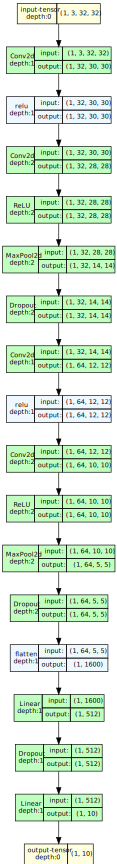

In [3]:
# 문제 5
class Cifar10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = self.build_layer(32, 32, 3, 1, "valid", 2, 0.25)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = self.build_layer(64, 64, 3, 1, "valid", 2, 0.25)
        
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=512)
        self.dr1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        
    def build_layer(self, in_channel, out_channel, kernel_size, stride, padding, pool_size, dropout):
        layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride,
                     padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool_size),
            nn.Dropout(dropout)
        )
        return layer
    
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = self.conv2(x)
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.dr1(self.fc1(x))
        out = self.fc2(x)
        return out
    

model = Cifar10_CNN()
# x = torch.zeros(1, 3, 32, 32)
# make_dot(model(x), params=dict(list(model.named_parameters())))
model_graph = draw_graph(model, input_size=(1, 3, 32, 32), device='meta')
model_graph.visual_graph

In [5]:
# 문제 06
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 32, 28, 28]           9,248
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
           Dropout-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 12, 12]          18,496
            Conv2d-7           [-1, 64, 10, 10]          36,928
              ReLU-8           [-1, 64, 10, 10]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Dropout-10             [-1, 64, 5, 5]               0
           Linear-11                  [-1, 512]         819,712
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 890,410
Trainable params:

In [ ]:
# 문제 07
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(10, activation="softmax")
model = Model(inputs, out)

In [67]:
# 문제 8
true = torch.from_numpy(np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])).unsqueeze(0)
true_ce = torch.from_numpy(np.array([5]))
case1_pred = torch.from_numpy(np.array([0.1, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0])).unsqueeze(0)
case2_pred = torch.from_numpy(np.array([0.4, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0])).unsqueeze(0)
eps=1e-10

ce = nn.NLLLoss()(torch.log(case1_pred), true_ce.type(torch.LongTensor))
mse = nn.MSELoss()(case1_pred, true)
print("case1: ", ce.item(), mse.item())

ce = nn.NLLLoss()(torch.log(case2_pred), true_ce.type(torch.LongTensor))
mse = nn.MSELoss()(case2_pred, true)
print("case2: ", ce.item(), mse.item())

case1:  0.10536051565782628 0.0028571428571428567
case2:  0.6931471805599453 0.05857142857142857


In [ ]:
# 문제 9
for momentum in [0.0, 0.1, 0.2]
    log_dir = "logs/fit/mlp_SGD_{}".format(momentum)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    mlp.compile(loss="MSE", optimizer=SGD(learning_rate=0.01, momentum=momentum), metrics=["accuracy"])
    mlp.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test), verbose=2,
           callbacks=[tensorboard_callback])

    res = mlp.evaluate(x_test, y_test, verbose=0)